# Authorship Attribution for Ancient Greek Literature
## Table of contents
1. [Introduction](#introduction)
    1. [Problem Area](#problem_area)
    1. [Objectives](#problem_area)
    1. [Dataset](#problem_area)
    1. [Evaluation Methodology](#problem_area)
1. [Install Packages](#install)
1. [Implementation](#implementation)
1. [Get data](#get-data)
1. [Run NLP pipeline with `NLP()`](#run-nlp)
1. [Inspect CLTK `Doc`](#inspect-doc)
1. [Inspect CLTK `Word`](#inspect-word)
1. [Modeling morphology with `MorphosyntacticFeature` and `MorphosyntacticFeatureBundle`](#morph)
1. [Modeling syntax with `Form` and `DependencyTree`](#syntax)
1. [Feature extraction](#features)
1. [Brief demonstration of `NLP()` for Ancient Greek](#greek-nlp)

## Introduction  <a name="introduction"></a>
### Problem Area <a name="problem_area"></a>
Authorship attribution has been a long-standing problem in the field of Ancient Greek literature study. Scholars have made a lot of effort in determining the genuine authorship of anonousy works, and giving answer to literatures of debated authorship.

In this study, we made attempts to address this issue by using Navie Bayes algorithm. 

### Objective
This study aims to address the authorship attribution problems in Greek Literature. We would first train a model using works with known authorship, and thereby try to give from the persepective of computational linguistic answers to the authorship of contested Greek works. 

### Dataset
We select 54 works from eleven ancient Greek authors that ranged from 8th BCE to 3rd CE. The topics covered include religons, philosophy, myth, history, drama, while the genres include poetry, prose, epic, comedy, tragedy, history and biography. The dataset was obtained from Wikisource and Project Gutenberg. A full list of reference of each work is included in the appendix.

### Evaluation methodology
We use Precision, Recall, F1-score and Accuracy to meausre the performance of our model.

### Result
For our model, TF-IDF measurement is used as the representation of corpus. Finally, we achieve 77% accuracy in authorship attribution.

## II. Implementation <a name="implementation"></a>


### Install Package  <a name="install"></a>
Firstly we install the required packages, and download the Greek corpus for CLTK before the Greek lemmatizer and tokenizer could be used.

In [119]:
# Download Packages
#pip install -i https://pypi.tuna.tsinghua.edu.cn/simple cltk nltk numpy pandas

# Get data from CLTK
#from cltk.data.fetch import FetchCorpus
#corpus_downloader = FetchCorpus(language="grc")

### Load Dataset
We need to load the corpus stored locally before preprocessing. The dataset is represented in plain text and stored in `.txt` format. The dataset is converted into a `dict` data structure, with keys representing the authors' names and the values representing a list of their works.

Corpus Data Structure:

corpus = \{  
    &nbsp;&nbsp; 'author 1'：\[ work1, work2, work3 ...\],  
    &nbsp;&nbsp; 'author 2'：\[ work1, work2, work3 ...\],  
    &nbsp;&nbsp; 'author 3'：\[ work1, work2, work3 ...\],  
    &nbsp;&nbsp; ...  
\}  

In [120]:
import os
import textwrap
import cltk

os.listdir('./raw text')
def get_corpus_dict_from_dir(path):
    files = os.listdir('./raw text')
    corpus_dict = {}
    for file in files:
        if '.txt' in file:
            author = file[:file.find('-')-1].strip()
            with open(path+'/'+file,'r',encoding='utf-8') as f:
                if corpus_dict.get(author) is None:
                    corpus_dict[author] = []
                corpus_dict[author].append(f.read())
    return corpus_dict

corpus_dict = get_corpus_dict_from_dir('./raw text')

print('Total: ', len([work for works in corpus_dict.values() for work in works]),' documents')
for author,docs in corpus_dict.items():
    print(author, 'has', len(docs),'text')

Total:  63  documents
Pindar has 4 text
Epicurus has 2 text
Aeschylus has 6 text
Pausanias has 1 text
Plato has 8 text
Xenophon has 14 text
Hesiod has 3 text
Aristotle has 8 text
Aristophanes has 8 text
Homer has 2 text
Saint John has 4 text
Luke has 2 text
Diogenes Laërtius has 1 text


### Segementation of text
A work in the copus presents a full publication. However, contested works often survives in fragments in Greek literature. Therefore, it is desired  that our model would be able to predict the authorship from a fragment of works. 

In order to give the model this capability, we divide works in the dataset into short fragments. However, we should be courious not to segement the works too small, since it is very unlikely to determine the authorship of a small paragraph. The writting style would not be obvious and work frequency distribution would not give insights to the authorship given the small size of paragraph. In this study, the size of a fragment is set to `5000` characters long. 

In [121]:
import textwrap
def segement_corpus(corpus,chunk_size):
#textwrap.wrap(cdict['Aristotle'][0], 5000)[0]
    corpus_segemented = {}
    chunk_size = 5000

    for author,docs in corpus.items():
        for doc in docs:
            if corpus_segemented.get(author) is None:
                corpus_segemented[author] = []
            corpus_segemented[author] += textwrap.wrap(doc,chunk_size)
    return corpus_segemented

corpus = segement_corpus(corpus_dict,chunk_size=5000)
for author,docs in corpus.items():
    print(author, ' has ', len(docs),' text')

    
print('\nExample: A fragment of Epicurus\' work\n',corpus['Epicurus'][0][:3000])

Pindar  has  30  text
Epicurus  has  4  text
Aeschylus  has  46  text
Pausanias  has  234  text
Plato  has  394  text
Xenophon  has  404  text
Hesiod  has  24  text
Aristotle  has  333  text
Aristophanes  has  116  text
Homer  has  261  text
Saint John  has  24  text
Luke  has  51  text
Diogenes Laërtius  has  144  text

Example: A fragment of Epicurus' work
 Κύριαι Δόξαι                                           Επίκουρος      εξάχθηκε από τη Βικιθήκη την 9 Ιουνίου 2022      Κύριαι Δόξαι  Συγγραφέας: Επίκουρος      1 Τὸ μακάριον καὶ ἄφθαρτον οὔτε αὐτὸ πράγματα ἔχει οὔτε ἄλλῳ παρέχει· ὥστε οὔτε ὀργαῖς οὔτε χάρισι συνέχεται· ἐν ἀσθενεῖ γὰρ πᾶν τὸ τοιοῦτον. (ἐν ἄλλοις δέ φησι τοὺς θεοὺς λόγῳ θεωρητούς͵ οὓς μὲν κατ΄ ἀριθμὸν ὑφεστῶτας͵ οὓς δὲ κατὰ ὁμοείδειαν͵ ἐκ τῆς συνεχοῦς ἐπιῤῥύσεως τῶν ὁμοίων εἰδώλων ἐπὶ τὸ αὐτὸ ἀποτετελεσμένων͵ ἀνθρωποειδεῖς.)  2 Ὁ θάνατος οὐδὲν πρὸς ἡμᾶς· τὸ γὰρ διαλυθὲν ἀναισθητεῖ͵ τὸ δ΄ ἀναισθητοῦν οὐδὲν πρὸς ἡμᾶς.  3 Ὅρος τοῦ μεγέθους τῶν ἡδονῶν ἡ παντὸς τοῦ ἀλγοῦ

### 5. Preprocessing <a name="preprocessing"></a>

#### Lemmatization


In [122]:
from cltk.lemmatize.grc import GreekBackoffLemmatizer
from cltk.alphabet.text_normalization import cltk_normalize
lemmatizer = GreekBackoffLemmatizer()
word = cltk_normalize('γρυπὸν')
lemmatizer.lemmatize([word])[0][1]

'γρυπὸν'

In [123]:
def greek_lemmatizer(word):
    return lemmatizer.lemmatize([word])[0][1]
greek_lemmatizer('γρυπὸν')

'γρυπὸν'

#### Tokenization
A function is defined to tokenize the Greek corpus. NLTK tokenizer for Greek language is used here as the tokenization function which would be used by the TF-IDF Vectorizer in the implementation section. 

However, stopwords in apocopic form, with which the vowel at the end of a word is removed, need extra attentions in the tokenization process so that they could be correctly removed in the stopwords removal stage. For example, "ἀλλά" (but) in the ancient Greek langauge often appears as "ἀλλ’", where the vowel "ά" is replaced by the apostrophe "’". This results in the incorrect tokenization that "ἀλλ’" is splited into two different tokens, "ἀλλ" and "’", instead of a single word "ἀλλ’"

In [124]:
import nltk
def greek_tokenizer(text):
    # Handling the apocopic form by replacing words in apocopic form by speical markers, 
    # which would later be substituted back to the original words
    processed_text = text.replace('ἀλλ’','tk_1')
    processed_text = processed_text.replace('ἀλλ\'','tk_1')
    
    processed_text = processed_text.replace('δ’','tk_2')
    processed_text = processed_text.replace('δ\'','tk_2')

    # Tokenization with NLTK's library
    words = nltk.word_tokenize(processed_text,language='greek')
    
    # Substitution for the original words
    for i in range(len(words)):
        if words[i] == 'tk_1':
            words[i] ='ἀλλ’'
            continue
        if words[i] == 'tk_2':
            words[i] ='δ’'
            continue
    return words

### Lemmatizer-Tokenizer

In [125]:
def greek_lemmatizer_tokenizer(text):
    tokenized_words = greek_tokenizer(text)
    lemmatized_words =  [lemmatizer.lemmatize([word])[0][1] for word in tokenized_words]
    return lemmatized_words
print(greek_tokenizer(corpus['Plato'][0])[:10])
greek_lemmatizer_tokenizer(corpus['Plato'][0])[:10]

['Πολιτεία', 'Πολιτεία', 'Συγγραφέας', ':', 'Πλάτων', 'Βιβλίο', 'Α', "'", 'Πολιτεία/Β→', 'Σωκράτης']


['Πολιτεία',
 'Πολιτεία',
 'Συγγραφέας',
 'punc',
 'Πλάτων',
 'Βιβλίο',
 'Α',
 'punc',
 'Πολιτεία/Β→',
 'Σωκράτης']

#### Stopwords Removal

In [126]:
grc_stoplist = cltk.stops.grc.STOPS
grc_stoplist.extend(['να','και','το','τα','θα','τον','που','την','μου','τη','από','για',
                    'κι','με','εις','του','είναι','των','της','ἦν','τους','τοῦτο','ταῦτα','ἐγώ',
                    'δ\'','δ᾽','δ’','σου','ἀλλ᾽','ἀλλ’','ἀλλά','ότι','δε','ο','η','ᾖ','ή','αὐτοῦ','φημί','λέγω','εἶπον','πᾶς''ἔχω','πολύς','ἐπεί','ποιέω','γ᾽',
                     'Διότι','μιν','πᾶς'])
grc_stoplist = [greek_lemmatizer(stop) for stop in grc_stoplist]

#### Remove numbers and puncutations

In [127]:
# import re
# for author in corpus_dict.keys():
#     for i in range(len(corpus_dict[author])):
#         corpus_dict[author][i] = re.sub('[0-9]','',corpus_dict[author][i])
#         corpus_dict[author][i] = re.sub("[\\[\\]!._,'@?\\\:;\`’\\(\\)\\%]",'',corpus_dict[author][i])
#         corpus_dict[author][i] = re.sub("[\\n]",' ',corpus_dict[author][i])
import re
for author in corpus.keys():
    for i in range(len(corpus[author])):
        corpus[author][i] = re.sub('[0-9]','',corpus[author][i])
        corpus[author][i] = re.sub("[\\[\\]!._,'@?\\\:;\\\(\\)\\%\\—\\{\\}\\*\\<\\>\\--\\``\\&\\·\\«\\»]",'',corpus[author][i])
        corpus[author][i] = re.sub("[\\n]",' ',corpus[author][i])
        corpus[author][i] = re.sub("[\\`\\`]",'',corpus[author][i])
        

In [128]:
for author in corpus_dict.keys():
    for i in range(len(corpus_dict[author])):
        corpus_dict[author][i] = corpus_dict[author][i].lower()

#### Undersampling

In [129]:
## Undersampling
import random

## Remove some samples from Plato's corpus
plato_corpus = corpus['Plato']
random.seed(1)
random.shuffle(plato_corpus)
corpus['Plato'] = plato_corpus[:250]

# Remove some from Aristotle's corpus
aristotle_corpus = corpus['Aristotle']
random.shuffle(aristotle_corpus)
corpus['Aristotle'] = aristotle_corpus[:250]

# Remove some from Aristotle's corpus
xenophon_corpus = corpus['Xenophon']
random.shuffle(xenophon_corpus)
corpus['Xenophon'] = xenophon_corpus[:250]

for author,docs in corpus.items():
    print(author, ' has ', len(docs),' text')

Pindar  has  30  text
Epicurus  has  4  text
Aeschylus  has  46  text
Pausanias  has  234  text
Plato  has  250  text
Xenophon  has  250  text
Hesiod  has  24  text
Aristotle  has  250  text
Aristophanes  has  116  text
Homer  has  261  text
Saint John  has  24  text
Luke  has  51  text
Diogenes Laërtius  has  144  text


#### Oversampling

In [130]:
luke_corpus = corpus['Luke']
random.shuffle(luke_corpus)
corpus['Luke'] = luke_corpus + luke_corpus[:int(len(luke_corpus)/2)]

for author,docs in corpus.items():
    print(author, ' has ', len(docs),' text')

Pindar  has  30  text
Epicurus  has  4  text
Aeschylus  has  46  text
Pausanias  has  234  text
Plato  has  250  text
Xenophon  has  250  text
Hesiod  has  24  text
Aristotle  has  250  text
Aristophanes  has  116  text
Homer  has  261  text
Saint John  has  24  text
Luke  has  76  text
Diogenes Laërtius  has  144  text


#### Labels for the target data

In [131]:
def get_author_by_index(authors,index):
    return authors[index]

authors= list(corpus.keys())
authors

['Pindar',
 'Epicurus',
 'Aeschylus',
 'Pausanias',
 'Plato',
 'Xenophon',
 'Hesiod',
 'Aristotle',
 'Aristophanes',
 'Homer',
 'Saint John',
 'Luke',
 'Diogenes Laërtius']

### Training Data and Target Data

In [132]:
all_train_data = []
all_target_data = []
for author,docs in corpus.items():
    for doc in docs:
        all_train_data.append(doc)
        all_target_data.append(authors.index(author))
print('There are ', len(all_train_data),' data')

There are  1709  data


In [133]:
# import re
## remove numbers
# for i in range(len(all_train_data)):
#     all_train_data[i] = re.sub('[0-9]','',all_train_data[i])
# for i in range(len(all_train_data)):
#     all_train_data[i] = re.sub("[\\[\\]!._,'@?\\\]",'',all_train_data[i])


In [134]:
from sklearn.utils import shuffle
all_train_data, all_target_data = shuffle(all_train_data, all_target_data, random_state=3)

In [135]:
train_data_boundary = int(len(all_train_data)/3 *2)
train_data = all_train_data[:train_data_boundary]
target_data = all_target_data[:train_data_boundary]
test_data = all_train_data[train_data_boundary:]
test_target_data=all_target_data[train_data_boundary:]

In [136]:
len(all_train_data)

1709

In [137]:
print('target: ',target_data[0])
print('This work is attributed to ',target_data[0],get_author_by_index(authors,target_data[0]))

target:  3
This work is attributed to  3 Pausanias


In [138]:
len(test_data)

570

## 7. Classification approach

In [139]:
vectorizer = TfidfVectorizer(tokenizer=greek_tokenizer,stop_words=grc_stoplist)
tfidf_model = vectorizer.fit(corpus['Plato'])
spare_result = tfidf_model.transform(corpus['Plato'])
spare_result

/home/ludwig/projects/CM3060 Natural Language Proccesing/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/ludwig/projects/CM3060 Natural Language Proccesing/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['διότι', 'δ’', 'ἀλλ’'] not in stop_words.
  warnings.warn(


<250x29503 sparse matrix of type '<class 'numpy.float64'>'
	with 98703 stored elements in Compressed Sparse Row format>

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer(tokenizer=greek_tokenizer,stop_words=grc_stoplist)

TfidfVectorizer(stop_words=['αὐτός', 'αὐτός', 'γε', 'γάρ', 'γάρ', "δ'", 'δαίς',
                            'δαὶς', 'δαί', 'δαίς', 'διά', 'διά', 'δέ', 'δέ',
                            'δή', 'δή', 'εἰ', 'εἰμί', 'εἰμί', 'εἰς', 'εἰμί',
                            'κατά', 'κατά', 'καί', 'καί', 'μετά', 'μετά', 'μέν',
                            'μέν', 'μή', ...],
                tokenizer=<function greek_tokenizer at 0x7fddbbe18160>)

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

nb_model = make_pipeline(TfidfVectorizer(tokenizer=greek_lemmatizer_tokenizer,stop_words=grc_stoplist), MultinomialNB())
nb_model.fit(train_data, target_data)
labels = nb_model.predict(test_data)

/home/ludwig/projects/CM3060 Natural Language Proccesing/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['διότι', 'εὐρύπορος'] not in stop_words.
  warnings.warn(


## Performance of the model

/home/ludwig/projects/CM3060 Natural Language Proccesing/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ludwig/projects/CM3060 Natural Language Proccesing/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ludwig/projects/CM3060 Natural Language Proccesing/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

                   precision    recall  f1-score   support

           Pindar       0.00      0.00      0.00        13
         Epicurus       0.00      0.00      0.00         2
        Aeschylus       0.00      0.00      0.00        13
        Pausanias       1.00      1.00      1.00        78
            Plato       0.98      0.90      0.94        93
         Xenophon       0.54      0.99      0.70        80
           Hesiod       0.00      0.00      0.00         9
        Aristotle       0.86      0.96      0.91        83
     Aristophanes       1.00      0.56      0.71        36
            Homer       0.68      1.00      0.81        80
       Saint John       0.00      0.00      0.00         4
             Luke       0.92      0.50      0.65        24
Diogenes Laërtius       1.00      0.29      0.45        55

         accuracy                           0.79       570
        macro avg       0.54      0.48      0.47       570
     weighted avg       0.79      0.79      0.75      

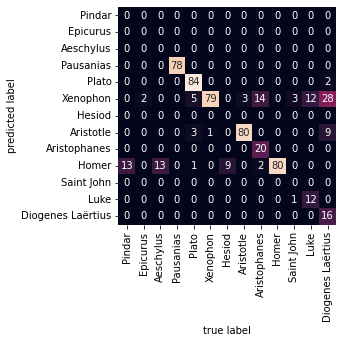

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_target_data, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=authors, yticklabels=authors)
plt.xlabel('true label')
plt.ylabel('predicted label');

from sklearn.metrics import classification_report
print(classification_report(test_target_data, labels, target_names=authors))

/home/ludwig/projects/CM3060 Natural Language Proccesing/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['διότι', 'εὐρύπορος'] not in stop_words.
  warnings.warn(
/home/ludwig/projects/CM3060 Natural Language Proccesing/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ludwig/projects/CM3060 Natural Language Proccesing/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

                   precision    recall  f1-score   support

           Pindar       0.33      0.08      0.12        13
         Epicurus       0.00      0.00      0.00         2
        Aeschylus       0.92      0.92      0.92        13
        Pausanias       0.97      0.99      0.98        78
            Plato       1.00      0.94      0.97        93
         Xenophon       0.90      0.99      0.94        80
           Hesiod       0.00      0.00      0.00         9
        Aristotle       0.86      0.99      0.92        83
     Aristophanes       1.00      0.92      0.96        36
            Homer       0.81      1.00      0.89        80
       Saint John       1.00      1.00      1.00         4
             Luke       1.00      0.96      0.98        24
Diogenes Laërtius       0.96      0.78      0.86        55

         accuracy                           0.91       570
        macro avg       0.75      0.73      0.73       570
     weighted avg       0.89      0.91      0.90      

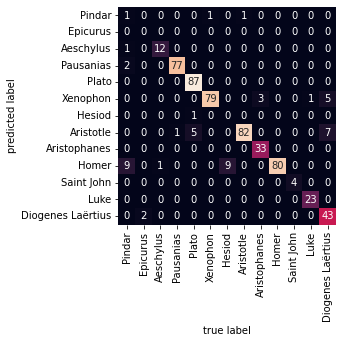

In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
random_forest_model = make_pipeline(TfidfVectorizer(tokenizer=greek_lemmatizer_tokenizer,stop_words=grc_stoplist), RandomForestClassifier())
random_forest_model.fit(train_data, target_data)
labels = random_forest_model.predict(test_data)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_target_data, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=authors, yticklabels=authors)
plt.xlabel('true label')
plt.ylabel('predicted label');

from sklearn.metrics import classification_report
print(classification_report(test_target_data, labels, target_names=authors))

In [144]:
aristotle_sample = '''Διά τούτο σχεδόν οι πλείστοι των φιλοσοφούντων περί της φύσεως, και εκ των ιατρών εκείνοι, οίτινες αντιλαμβάνονται την τέχνην αυτών κατά τρόπον φιλοσοφικώτερον, εκείνοι μεν εκ της μελέτης της φύσεως καταντώσι τέλος εις την ιατρικήν, οι άλλοι δε αρχίζουσι την τέχνην εκ των νόμων της φύσεως και της εφαρμογής αυτών εις την ιατρικήν. 6. Ότι δε αι ρηθείσαι λειτουργίαι πάσαι είναι κοιναί και της ψυχής και του σώματος, είναι φανερόν. Διότι πάσαι συμβαίνουσιν, άλλαι ομού με την αίσθησιν {7} άλλαι δε διά της αισθήσεως {8}. Άλλαι μεν είναι παθήσεις της αισθήσεως, άλλαι δε είναι διαρκείς καταστάσεις αυτής, άλλαι είναι λειτουργίαι προς φύλαξιν και συντήρησιν αυτής {9} και άλλαι είναι φθοραί και στερήσεις αυτής {10}. Ότι δε η αίσθησις συμβαίνει εις την ψυχήν διά μέσου του σώματος, τούτο γίνεται φανερόν και διά του λόγου και άνευ του λόγου (διά της πείρας) {11}. 7. Αλλ' έχομεν είπει εν τη περί ψυχής πραγματεία τας θεωρίας ημών περί αισθήσεως και περί του αισθάνεσθαι και διατί συμβαίνει εις τα ζώα τούτο το πάθος. Έκαστον ζώον, καθό ζώον, πρέπει κατ' ανάγκην να έχη αίσθησιν• διά ταύτης διακρίνομεν το ζώον από παντός όπερ δεν είναι ζώον. 8. Πάντα δε τα ζώα, ατομικώς έκαστον έχουσιν εξ ανάγκης την αφήν και την γεύσιν, την μεν αφήν, διά την αιτίαν την οποίαν είπομεν εις την περί ψυχής πραγματείαν, {12} την δε γεύσιν διά την τροφήν. Διότι διά της γεύσεως διακρίνει το ευάρεστον και το δυσάρεστον εις τας τροφάς το ζώον, και ούτως αποφεύγει τας δυσάρεστους τροφάς, επιζητεί δε τας ευαρέστους, και εν γένει ο χυμός {13} είναι πάθος του θρεπτικού μέρους της ψυχής. 9. Αι δε αισθήσεις αι διεγειρόμεναι υπό των εξωτερικών πραγμάτων π.χ. η όσφρησις, η ακοή και η όψις, εις πάντα τα πορευτικά (κινούμενα) ζώα, τα έχοντα αυτάς, υπάρχουσι χάριν της συντηρήσεις των, όπως προαισθανόμενα την τροφήν επιδιώκωσιν αυτήν, φεύγωσι δε τα κακά και επιβλαβή. Εις δε τα ζώα, τα οποία έχουσι και νόησιν, αι αισθήσεις αυταί υπάρχουσι χάριν της ευζωίας• διότι γνωστοποιούσιν εις αυτά πολλάς διαφοράς των πραγμάτων, εξ ων προέρχεται η γνώσις εκείνων τα οποία δύνανται να νοηθώσι και εκείνων τα οποία πρέπει να πραχθώσι (των νοητών και των πρακτικών ιδεών). '''
aristotle_sample_label = model.predict([aristotle_sample])
print(aristotle_sample_label)
print('This work is attributed to ',get_author_by_index(authors,aristotle_sample_label[0]))

[7]
This work is attributed to  Aristotle


In [145]:
luke_sample = '''Ταῦτα δὲ αὐτῶν λαλούντων,.'''

In [146]:
luke_sample_label = model.predict([luke_sample])
print(luke_sample_label)
print('This work is attributed to ',get_author_by_index(authors,luke_sample_label[0]))

[11]
This work is attributed to  Luke


In [191]:
from tabulate import tabulate
def load_text(path):
    with open(path,'r') as f:
        text = f.read()
    return text
def clean_text(text):
    text = re.sub('[0-9]','',text)
    text = re.sub("[\\[\\]!._,'@?\\\:;\\\(\\)\\%\\—\\{\\}\\*\\<\\>\\--\\``\\&\\·\\«\\»]",'',text)
    text = re.sub("[\\n\\t]",' ',text)
    text = re.sub("[\\`\\`]",'',text)
    return text

def predict_author(model,text):
    return get_author_by_index(authors,model.predict([text])[0])

homeric_hymns = load_text('./Testing Data/Homeric Hymns.txt')
homeric_hymns = clean_text(homeric_hymns)
homeric_hymns_author = predict_author(random_forest_model,homeric_hymns)


promeheus = load_text('./Testing Data/Prometheus Bound.txt')
promeheus = clean_text(promeheus_hymns)
promeheus_author = predict_author(random_forest_model,promeheus_hymns)

random_forest_result= ('Random Forest',homeric_hymns_author,promeheus_author)

homeric_hymns_author = predict_author(nb_model,homeric_hymns)
promeheus_author = predict_author(nb_model,promeheus_hymns)

nb_result= ('Navie Bayes',homeric_hymns_author,promeheus_author)

headers = ["Model","Homeric Hymns","Promeheus Bound"]
print(tabulate([random_forest_result,nb_result],headers=headers,tablefmt='fancy_grid'))

╒═══════════════╤═════════════════╤═══════════════════╕
│ Model         │ Homeric Hymns   │ Promeheus Bound   │
╞═══════════════╪═════════════════╪═══════════════════╡
│ Random Forest │ Homer           │ Aeschylus         │
├───────────────┼─────────────────┼───────────────────┤
│ Navie Bayes   │ Homer           │ Homer             │
╘═══════════════╧═════════════════╧═══════════════════╛


In [147]:
import re
with open('./Testing Data/Homeric Hymns.txt','r') as f:
    homeric_hymns = f.read()
print('Text Sample:\n',homeric_hymns[:100])

# Cleaning the text


print('\nClean Text Sample:\n',homeric_hymns[:100])


Text Sample:
 Ὁμηρικοὶ ὕμνοι


					Άγνωστος





εξάχθηκε από τη Βικιθήκη την 17 Ιουνίου 2022





Ὁμηρικοὶ ὕμνοι

Clean Text Sample:
 Ὁμηρικοὶ ὕμνοι        Άγνωστος      εξάχθηκε από τη Βικιθήκη την  Ιουνίου       Ὁμηρικοὶ ὕμνοι  Συγγ


In [148]:
homeric_hymns_label = model.predict([homeric_hymns])
print('This work is attributed to ',get_author_by_index(authors,homeric_hymns_label[0]))

This work is attributed to  Homer


In [177]:
import re
with open('./Testing Data/Prometheus Bound.txt','r') as f:
    homeric_hymns = f.read()
print('Text Sample:\n',homeric_hymns[:100])

# Cleaning the text
homeric_hymns = re.sub('[0-9]','',homeric_hymns)
homeric_hymns = re.sub("[\\[\\]!._,'@?\\\:;\\\(\\)\\%\\—\\{\\}\\*\\<\\>\\--\\``\\&\\·\\«\\»]",'',homeric_hymns)
homeric_hymns = re.sub("[\\n\\t]",' ',homeric_hymns)
homeric_hymns = re.sub("[\\`\\`]",'',homeric_hymns)

print('\nClean Text Sample:\n',homeric_hymns[:100])

homeric_hymns_label = model.predict([homeric_hymns])
print('This work is attributed to ',get_author_by_index(authors,homeric_hymns_label[0]))

Text Sample:
 Προμηθεὺς Δεσμώτης


					Αισχύλος





εξάχθηκε από τη Βικιθήκη την 17 Ιουνίου 2022





Προμηθεὺς 

Clean Text Sample:
 Προμηθεὺς Δεσμώτης        Αισχύλος      εξάχθηκε από τη Βικιθήκη την  Ιουνίου       Προμηθεὺς Δεσμώτ
This work is attributed to  Aeschylus


In [149]:
model.predict_proba([luke_sample])


array([[0.02, 0.  , 0.03, 0.  , 0.  , 0.02, 0.1 , 0.27, 0.12, 0.01, 0.  ,
        0.33, 0.1 ]])

In [150]:
def get_freq_dist_from_corpus(docs):
    cgrc_stoplist = cltk.stops.grc.STOPS
    cgrc_stoplist.extend(['να','και','το','τα','θα','τον','που','την','μου','τη','από','για',
                        'κι','με','εις','του','είναι','των','της','ἦν','τους','τοῦτο','ταῦτα','ἐγώ',
                        'δ\'','δ᾽','δ’','σου','ἀλλ᾽','ἀλλ’','ἀλλά','ότι','δε','ο','η','ᾖ','ή','αὐτοῦ','φημί','λέγω','εἶπον','πᾶς''ἔχω','πολύς',
    'ἐπεί','γ᾽'])
    cgrc_stoplist = [greek_lemmatizer(stop) for stop in cgrc_stoplist]
    corpus_string = ''
    for doc in docs:
        corpus_string+=doc
    corpus_words = greek_lemmatizer_tokenizer(corpus_string)
    clean_words = [word for word in corpus_words if word not in cgrc_stoplist]
    freq_dist = nltk.probability.FreqDist(clean_words)
    return freq_dist

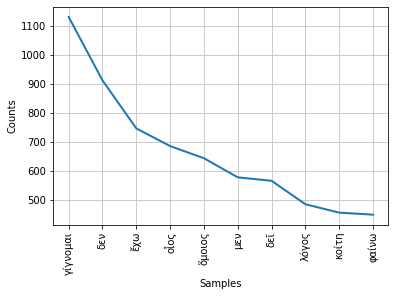

[('γίγνομαι', 1132),
 ('δεν', 913),
 ('ἔχω', 747),
 ('οἷος', 686),
 ('ὅμοιος', 644),
 ('μεν', 578),
 ('δεῖ', 566),
 ('λόγος', 485),
 ('κοίτη', 456),
 ('φαίνω', 449),
 ('οι', 439),
 ('όμως', 435),
 ('διότι', 418),
 ('ὅσος', 409),
 ('μόνος', 408),
 ('μέγας', 401),
 ('πόλις', 397),
 ('προς', 393),
 ('δ', 388),
 ('εἷς', 388)]

In [151]:
aristotle_freq_dist = get_freq_dist_from_corpus(corpus['Aristotle'])
aristotle_freq_dist.plot(10)
aristotle_freq_dist.most_common(20)

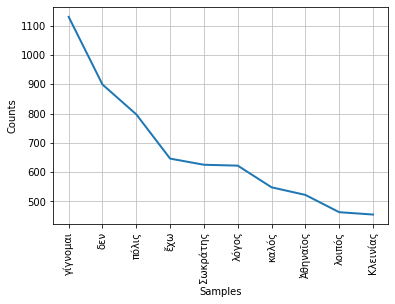

[('γίγνομαι', 1130),
 ('δεν', 899),
 ('πόλις', 797),
 ('ἔχω', 646),
 ('Σωκράτης', 625),
 ('λόγος', 622),
 ('καλός', 548),
 ('Ἀθηναῖος', 522),
 ('λοιπός', 463),
 ('Κλεινίας', 455)]

In [152]:
plato_freq_dist = get_freq_dist_from_corpus(corpus['Plato'])
plato_freq_dist.plot(10)
plato_freq_dist.most_common(10)

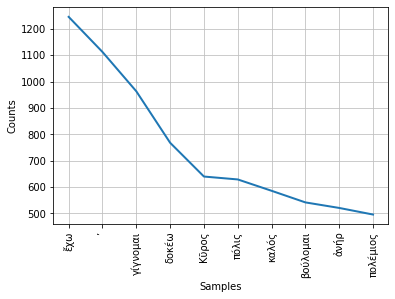

[('ἔχω', 1245),
 ('’', 1112),
 ('γίγνομαι', 963),
 ('δοκέω', 768),
 ('Κῦρος', 640),
 ('πόλις', 629),
 ('καλός', 586),
 ('βούλομαι', 542),
 ('ἀνήρ', 521),
 ('πολέμιος', 496),
 ('δ', 463),
 ('ἀγαθός', 453),
 ('δύναμαι', 449),
 ('λαμβάνω', 449),
 ('ὁράω', 436),
 ('δεῖ', 413),
 ('ἄνθρωπος', 403),
 ('ἐκεῖνος', 401),
 ('οἶδα', 395),
 ('νῦν', 377)]

In [153]:
xenophon_freq_dist = get_freq_dist_from_corpus(corpus['Xenophon'])
xenophon_freq_dist.plot(10)
xenophon_freq_dist.most_common(20)

In [154]:
for doc in corpus['Xenophon']:
    if 'punc' in doc:
        print('true')
        break

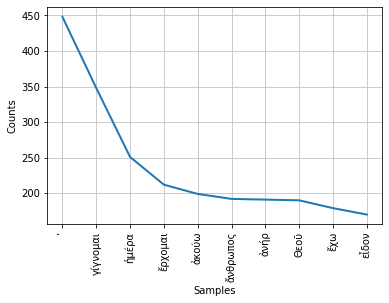

[('’', 448),
 ('γίγνομαι', 348),
 ('ἡμέρα', 251),
 ('ἔρχομαι', 212),
 ('ἀκούω', 199),
 ('ἄνθρωπος', 192),
 ('ἀνήρ', 191),
 ('Θεοῦ', 190),
 ('ἔχω', 179),
 ('εἶδον', 170),
 ('λόγος', 136),
 ('υἱός', 132),
 ('λαός', 128),
 ('λαλέω', 126),
 ('πορεύω', 122),
 ('δίδωμι', 122),
 ('εἰσέρχομαι', 122),
 ('πόλις', 122),
 ('ὄνομα', 122),
 ('πατήρ', 121)]

In [155]:
luke_freq_dist = get_freq_dist_from_corpus(corpus['Luke'])
luke_freq_dist.plot(10)
luke_freq_dist.most_common(20)

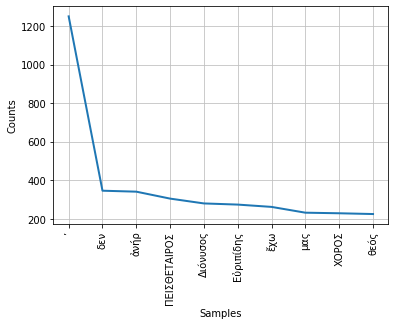

[('’', 1250),
 ('δεν', 346),
 ('ἀνήρ', 341),
 ('ΠΕΙΣΘΕΤΑΙΡΟΣ', 305),
 ('Διόνυσος', 280),
 ('Εὐριπίδης', 274),
 ('ἔχω', 262),
 ('μας', 232),
 ('ΧΟΡΟΣ', 229),
 ('θεός', 225),
 ('Α', 218),
 ('Δικ', 207),
 ('Χρεμύλος', 203),
 ('νῦν', 197),
 ('Ζεύς', 178),
 ('λαμβάνω', 177),
 ('πόλις', 177),
 ('ΑΛΛΑΝΤΟΠΩΛΗΣ', 175),
 ('νή', 174),
 ('Μνησίλοχος', 167)]

In [156]:
aristophanes_freq_dist = get_freq_dist_from_corpus(corpus['Aristophanes'])
aristophanes_freq_dist.plot(10)
aristophanes_freq_dist.most_common(20)

In [157]:
set([e[0] for e in aristophanes_freq_dist.most_common(20)]).intersection(set([e[0] for e in xenophon_freq_dist.most_common(20)]))

{'λαμβάνω', 'νῦν', 'πόλις', 'ἀνήρ', 'ἔχω', '’'}

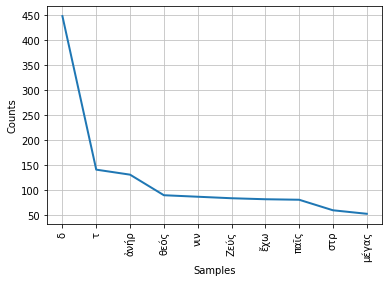

[('δ', 447),
 ('τ', 141),
 ('ἀνήρ', 131),
 ('θεός', 90),
 ('νιν', 87),
 ('Ζεύς', 84),
 ('ἔχω', 82),
 ('παῖς', 81),
 ('στρ', 60),
 ('μέγας', 53),
 ('χείρ', 50),
 ('αντ', 50),
 ('πατήρ', 49),
 ('λόγος', 48),
 ('ἀλλ', 47),
 ('ἔρχομαι', 47),
 ('επωδή', 47),
 ('καλός', 45),
 ('ἀμφί', 45),
 ('φέρω', 44)]

In [158]:
aristophanes_freq_dist = get_freq_dist_from_corpus(corpus['Pindar'])
aristophanes_freq_dist.plot(10)
aristophanes_freq_dist.most_common(20)

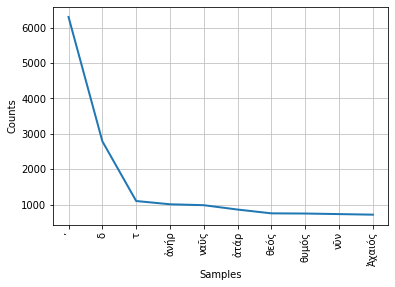

[('’', 6297),
 ('δ', 2792),
 ('τ', 1108),
 ('ἀνήρ', 1016),
 ('ναῦς', 990),
 ('ἀτάρ', 867),
 ('θεός', 760),
 ('θυμός', 755),
 ('νῦν', 739),
 ('Ἀχαιός', 723),
 ('Ὀδυσσεύς', 720),
 ('ἔρχομαι', 708),
 ('ἔχω', 707),
 ('Ζεύς', 706),
 ('φίλος', 657),
 ('μέγας', 648),
 ('Τρώς', 637),
 ('υἱός', 612),
 ('χείρ', 609),
 ('δίδωμι', 465)]

In [159]:
aristophanes_freq_dist = get_freq_dist_from_corpus(corpus['Homer'])
aristophanes_freq_dist.plot(10)
aristophanes_freq_dist.most_common(20)

In [160]:
'Και'.lower()

'και'

In [161]:
# from cltk.embeddings.processes import  GreekEmbeddingsProcess
# from cltk.core.data_types import Doc
# grc_emd = GreekEmbeddingsProcess()
# grc_emd.run(input_doc=Doc(raw=corpus['Plato'][0]))


In [162]:
x_string = ''
for doc in corpus['Aristotle']:
    x_string+=doc
tokenized_words = greek_tokenizer(x_string)
for word in tokenized_words:
    if lemmatizer.lemmatize(word)[0][1] =='punc':
        print(word)

``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
``
''
''
``
''
``
''
``
''
``
``
''
``
''
``
''
``
''
``
''
``
''
``


In [163]:
from sklearn.base import BaseEstimator,TransformerMixin
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
class CountSentenceLengthDictVectorizer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y):
        return self
    def transform(self,text_list):
        author_sent_length_dict = {}
        for author,docs in text_list.items():
            for doc in docs:
                
                author_sent_length_dict[author] = [np.mean([len(sent) for sent in sent_tokenize(doc)])]
        return author_sent_length_dict

In [164]:
from sklearn.base import BaseEstimator,TransformerMixin
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
class CountLineLengthDictVectorizer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y):
        return self
    def transform(self,text_list):
        author_sent_length_dict = {}
        for author,docs in text_list.items():
            for doc in docs:
                author_sent_length_dict[author] = [np.mean([len(line) for line in doc.split('\n')])]
        return author_sent_length_dict

In [165]:
cv = CountLineLengthDictVectorizer()
cv.transform(corpus_dict)

{'Pindar': [20.410106899902818],
 'Epicurus': [103.57142857142857],
 'Aeschylus': [17.09278350515464],
 'Pausanias': [222.9453951163238],
 'Plato': [359.7991967871486],
 'Xenophon': [284.6373626373626],
 'Hesiod': [20.30647291941876],
 'Aristotle': [238.65293383270912],
 'Aristophanes': [24.51397174254317],
 'Homer': [21.05632561249924],
 'Saint John': [438.5373831775701],
 'Luke': [355.57549857549856],
 'Diogenes Laërtius': [61.829310947883876]}

In [166]:
from sklearn.base import BaseEstimator,TransformerMixin
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
class CountSentenceLengthVectorizer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        self.X=X
        self.y=y
        return self
    def transform(self,X):
        y=self.y
        result=[]

        for i in range(len(X)):
            doc = X[i]
            author = y[i]
            sent_lengths=[]
            for sent in sent_tokenize(doc):
                sent_lengths.append(len(sent))
            result.append([np.mean(sent_lengths)])
        #return pd.DataFrame(author_avg_sent_length_dict).to_numpy().transpose()
        return result

In [167]:
from sklearn.base import BaseEstimator,TransformerMixin
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
class CountLineLengthVectorizer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        self.X=X
        self.y=y
        return self
    def transform(self,X):
        y=self.y
        result=[]

        for i in range(len(X)):
            doc = X[i]
            author = y[i]
            line_lengths=[]
            for line in doc.split('\n'):
                if line != '':
                    line_lengths.append(len(line))
            result.append([np.mean(line_lengths)])
        #return pd.DataFrame(author_avg_sent_length_dict).to_numpy().transpose()
        return result

In [168]:
# from sklearn.base import BaseEstimator,TransformerMixin
# from nltk.tokenize import sent_tokenize
# import pandas as pd
# import numpy as np
# class CountLineLengthVectorizer(BaseEstimator,TransformerMixin):
#     def __init__(self):
#         pass
#     def fit(self,X,y=None):
#         self.X=X
#         self.y=y
#         return self
#     def transform(self,X):
#         y=self.y
#         result=[]

#         for i in range(len(X)):
#             doc = X[i]
#             author = y[i]
#             line_lengths=[]
#             for line in doc.split('\n'):
#                 if line != '':
#                     line_lengths.append(len(line))
#             result.append(line_lengths)
#         #return pd.DataFrame(author_avg_sent_length_dict).to_numpy().transpose()
#         return result

In [169]:
from sklearn.base import BaseEstimator,TransformerMixin
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
class CountParticleVectorizer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        self.X=X
        self.y=y
        return self
    def transform(self,X):
        y=self.y
        result=[]

        for i in range(len(X)):
            doc = X[i]
            author = y[i]
            line_lengths=[]
            for line in doc.split('\n'):
                if line != '':
                    line_lengths.append(len(line))
            result.append([np.mean(line_lengths)])
        #return pd.DataFrame(author_avg_sent_length_dict).to_numpy().transpose()
        return result

In [170]:
corpus_dict = get_corpus_dict_from_dir('./raw text')
import textwrap
#textwrap.wrap(cdict['Aristotle'][0], 5000)[0]
corpus = {}
chunk_size = 5000

for author,docs in corpus_dict.items():
    for doc in docs:
        if corpus.get(author) is None:
            corpus[author] = []
        corpus[author] += textwrap.wrap(doc,chunk_size,break_long_words=False,replace_whitespace=False)

for author,docs in corpus.items():
    print(author, ' has ', len(docs),' text')

Pindar  has  30  text
Epicurus  has  4  text
Aeschylus  has  46  text
Pausanias  has  234  text
Plato  has  394  text
Xenophon  has  404  text
Hesiod  has  24  text
Aristotle  has  333  text
Aristophanes  has  116  text
Homer  has  261  text
Saint John  has  24  text
Luke  has  51  text
Diogenes Laërtius  has  144  text


In [171]:
all_train_data = []
all_target_data = []
for author,docs in corpus.items():
    for doc in docs:
        all_train_data.append(doc)
        all_target_data.append(authors.index(author))
print('There are ', len(all_train_data),' data')

There are  2065  data


In [172]:
cv = CountLineLengthVectorizer()
cv.fit(all_train_data,all_target_data)
df = pd.DataFrame(cv.transform(all_train_data))
df

,0
0,39.090909
1,39.633333
2,42.936937
3,39.297521
4,45.932692
...,...
2060,331.466667
2061,330.933333
2062,292.176471
2063,190.384615


In [173]:
df

,0
0,39.090909
1,39.633333
2,42.936937
3,39.297521
4,45.932692
...,...
2060,331.466667
2061,330.933333
2062,292.176471
2063,190.384615


In [174]:
len_list = []
for sent in sent_tokenize(corpus['Plato'][0]):
    len_list.append(len(sent))
np.mean(len_list)

123.5

                   precision    recall  f1-score   support

           Pindar       0.09      0.08      0.08        13
         Epicurus       0.00      0.00      0.00         2
        Aeschylus       0.19      0.23      0.21        13
        Pausanias       0.32      0.44      0.37        78
            Plato       0.17      0.17      0.17        93
         Xenophon       0.32      0.39      0.35        80
           Hesiod       0.00      0.00      0.00         9
        Aristotle       0.15      0.11      0.12        83
     Aristophanes       0.11      0.06      0.07        36
            Homer       0.43      0.46      0.45        80
       Saint John       0.00      0.00      0.00         4
             Luke       0.20      0.29      0.24        24
Diogenes Laërtius       0.14      0.07      0.10        55

         accuracy                           0.25       570
        macro avg       0.16      0.18      0.17       570
     weighted avg       0.23      0.25      0.24      

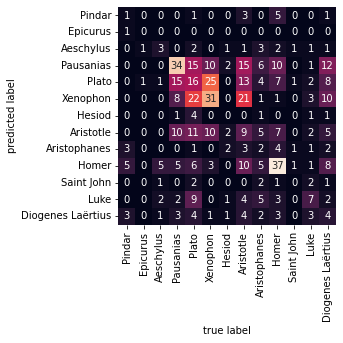

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

new_model = make_pipeline(CountLineLengthVectorizer(), RandomForestClassifier())
new_model.fit(X=train_data, y=target_data)
labels = new_model.predict(test_data)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_target_data, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=authors, yticklabels=authors)
plt.xlabel('true label')
plt.ylabel('predicted label');

from sklearn.metrics import classification_report
print(classification_report(test_target_data, labels, target_names=authors))

In [176]:
print(corpus['Pindar'][0].split('\n'))

['Νεμεόνικοι', '', '', '', '', '', 'εξάχθηκε από τη Βικιθήκη την 15 Ιουνίου 2022', '', '', '', '', '', 'Νεμεόνικοι', '', '', '', 'Πίνδαρος', '', '', '', '', '', 'ΧΡΟΜΙῼ ΑΙΤΝΑΙῼ ΙΠΠΟΙΣ', '', '', 'ἄμπνευμα σεμνὸν Ἀλφεοῦ,', '', 'κλεινᾶν Συρακοσσᾶν θάλος Ὀρτυγία,', '', 'δέμνιον Ἀρτέμιδος,', '', 'Δάλου κασιγνήτα, σέθεν ἁδυεπὴς 5', '', 'ὕμνος ὁρμᾶται θέμεν', '', 'αἶνον ἀελλοπόδων μέγαν ἵππων, Ζηνὸς Αἰτναίου χάριν:', '', "[10] ἅρμα δ' ὀτρύνει Χρομίου Νεμέα θ' ἔργμασιν νικαφόροις ἐγκώμιον ζεῦξαι μέλος.", '', 'ἀρχαὶ δὲ βέβληνται θεῶν', '', 'κείνου σὺν ἀνδρὸς δαιμονίαις ἀρεταῖς. 10', '', "ἔστι δ' ἐν εὐτυχίᾳ", '', "πανδοξίας ἄκρον: μεγάλων δ' ἀέθλων", '', 'Μοῖσα μεμνᾶσθαι φιλεῖ.', '', 'σπεῖρέ νυν ἀγλαΐαν τινὰ νάσῳ, τὰν Ὀλύμπου δεσπότας', '', '[20] Ζεὺς ἔδωκεν Φερσεφόνᾳ, κατένευσέν τέ οἱ χαίταις, ἀριστεύοισαν εὐκάρπου χθονὸς 15', '', 'Σικελίαν πίειραν ὀρθώσειν κορυφαῖς πολίων ἀφνεαῖς.', '', 'ὤπασε δὲ Κρονίων πολέμου μναστῆρά οἱ χαλκεντέος', '', 'λαὸν ἵππαιχμον θαμὰ δὴ καὶ Ὀλυμπιάδων φύλλοις ἐλαιᾶν

## Dataset

Meno \
Μένων by Plato:\
https://www.gutenberg.org/ebooks/34881


Απολογία Σωκράτους \
Socrates' Apology, by Plato and Alexandros Moraitides:\
https://www.gutenberg.org/ebooks/39462

Πολιτεία, Τόμος 4 \
Republic Volume 4 (of 4), by Plato: \
https://www.gutenberg.org/ebooks/39530



Όρνιθες \
The Birds, by Aristophanes:\
https://www.gutenberg.org/ebooks/27315

Lysistrata\
Λυσιστράτη by Aristophanes: \
https://www.gutenberg.org/ebooks/17814

Τίμαιος, Τόμος \
Timaeus, by Plato \
https://www.gutenberg.org/ebooks/35453

Hippias\
Ελάσσων, by Plato\
https://www.gutenberg.org/ebooks/34880

Ηθικά Νικομάχεια, Τόμος Πρώτος \
Nicomachean Ethics, Volume 1, by Aristotle \
https://www.gutenberg.org/ebooks/28626

Αθηναίων Πολιτεία \
The Constitution of the Athenians, by Aristotle \
https://www.gutenberg.org/ebooks/39963

Περί Ψυχής \
On the Soul, by Aristoteles \
https://www.gutenberg.org/ebooks/27816